#  Text Classification - Sentiment Analysis
## Comparative Study of Various Numerical Representations of Text

***

## Import all necessary libraries

In [ ]:
# imports 
import pandas as pd
import numpy as np
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import pprint

***

## Labelled Tweets - Text Corpus


In [ ]:
tweets = pd.read_csv('tweets.csv')
tweets.head()

,sentiment,text,selected_text
0,positive,so great to see oin &amp; cynthia. so happy. ...,so great to see oin &amp; cynthia. so happy.
1,positive,bought a new combo printer at costco today (of...,cheaper than ink 4 old one. #windows7 doesn't...
2,positive,freedom,freedom
3,negative,its funny. i'm kinda sad on my last day,sad
4,positive,@_bella_cullen13 @rosaliehcullen @esme_cullen2...,girls love


In [ ]:
tweets.shape

(8493, 3)

In [ ]:
tweet_text = tweets['text']
tweet_text.head()

0    so great to see oin &amp; cynthia.  so happy. ...
1    bought a new combo printer at costco today (of...
2                                              freedom
3              its funny. i'm kinda sad on my last day
4    @_bella_cullen13 @rosaliehcullen @esme_cullen2...
Name: text, dtype: object

### Label Encoding 

In [ ]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
tweets['sentiment_le'] = labelencoder.fit_transform(tweets['sentiment'])

tweets.head()

,sentiment,text,selected_text,sentiment_le
0,positive,so great to see oin &amp; cynthia. so happy. ...,so great to see oin &amp; cynthia. so happy.,2
1,positive,bought a new combo printer at costco today (of...,cheaper than ink 4 old one. #windows7 doesn't...,2
2,positive,freedom,freedom,2
3,negative,its funny. i'm kinda sad on my last day,sad,0
4,positive,@_bella_cullen13 @rosaliehcullen @esme_cullen2...,girls love,2


In [ ]:
tweet_sentiment_labels = tweets['sentiment_le']
tweet_sentiment_labels.head()

0    2
1    2
2    2
3    0
4    2
Name: sentiment_le, dtype: int64

***

## 1/ Bag of Words Approach (using SpaCy)

### Setup spacy enlish vocab based model

In [ ]:
# create empty model
nlp = spacy.blank("en")

# create the `textcategorizer` pipe with the given parameter settings
textcat = nlp.create_pipe(
    "textcat", # internal name of the pipe
    config={
        "exclusive_classes": True, # set "exclusive_classes" parameter to "True" (spam or ham output based on input - i.e. discrete classification output of input text)
        "architecture": "bow", # set the pipe "architecture" parameter to "bow" (bag-of-words model)
    }
)

# add the newly created pipe to the blank nlp model
nlp.add_pipe(textcat)

### SpaCy labels

In [ ]:
# Add labels to text classifier
textcat.add_label("positive")
textcat.add_label("neutral")
textcat.add_label("negative")

1

### Extract input texts

In [ ]:
X_bow = tweets['text']
print(X_bow)

0       so great to see oin &amp; cynthia.  so happy. ...
1       bought a new combo printer at costco today (of...
2                                                 freedom
3                 its funny. i'm kinda sad on my last day
4       @_bella_cullen13 @rosaliehcullen @esme_cullen2...
                              ...                        
8488    auto uit de running... one down, one yet to build
8489    9:30pm and this grandma is going to sleep.  20...
8490    aaauuuggghhh! in n out, check! mcdonald's, che...
8491                scratch that; sleep on a stage bound.
8492                     wishes she was in boston for dmb
Name: text, Length: 8493, dtype: object


### Extract labels

In [ ]:
y_bow = [{'cats':{
    'positive': label == 'positive',
    'neutral': label == 'neutral',
    'negative': label == 'negative'
}} for label in tweets['sentiment']]
print(y_bow)

[{'cats': {'positive': True, 'neutral': False, 'negative': False}}, {'cats': {'positive': True, 'neutral': False, 'negative': False}}, {'cats': {'positive': True, 'neutral': False, 'negative': False}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': True, 'neutral': False, 'negative': False}}, {'cats': {'positive': False, 'neutral': True, 'negative': False}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': False, 'neutral': False, 'negative': True}}, {'cats': {'positive': False, 'neutral': True, 'negative': False}}, {'cats': {'positive': False, 'neutral': True, 'negative': False}}, {'cats': {'positive': False, 'neutral': True, 'negative': False}}, {'cats': {'positive': False, 'neutral': False, 'negative': Tr

### Train-Test Split 

In [ ]:
# split into train test sets
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_bow, test_size=0.20, random_state=0)

In [ ]:
len(X_train_bow)

6794

In [ ]:
len(y_train_bow)

6794

In [ ]:
len(X_test_bow)

1699

In [ ]:
len(y_test_bow)

1699

### Setup Batcher

In [ ]:
train_data = list(zip(X_train_bow, y_train_bow))

# setup the batch processor
from spacy.util import minibatch

spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

batches = minibatch(train_data,size = 8)

# iterate throguh the minibatches 
for batch in batches:
    # each batch is a list of (text,label)
    # but send separate lists for text and labels to update()
    # quick way to split a list of tuples into lists 
    texts, labels = zip(*batch)
    nlp.update(texts, labels, sgd=optimizer)


### Multiple Epochs

In [ ]:
import random

random.seed(1)
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

losses = {} # init a blank dictionary for storing the losses at each update
number_of_epochs = 1 # set the number of epochs to run

for epoch in range(number_of_epochs):

    # shuffle training data at the beginning of the epoch
    random.shuffle(train_data)

    # create the batch generator with bathc size = 8
    batches = minibatch(train_data, size=8)

    # iterate throguh the minibatches 
    for batch in batches:
        texts, labels = zip(*batch)
        nlp.update(texts, labels, sgd = optimizer, losses = losses)
    print(losses)

{'textcat': 7.051193565130234}


### Making Predictions on Test Data

In [ ]:
docs = [nlp.tokenizer(text) for text in X_test_bow]
    
# Use textcat to get the scores for each doc
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(docs)

print(scores)

[[0.27264145 0.44097704 0.28638148]
 [0.10126158 0.09317978 0.8055587 ]
 [0.62911946 0.19157583 0.17930478]
 ...
 [0.69720525 0.09408572 0.20870909]
 [0.265118   0.29908898 0.43579304]
 [0.23311278 0.39863646 0.36825076]]


In [ ]:
predicted_labels = scores.argmax(axis=1)
final_pred_bow = [textcat.labels[label] for label in predicted_labels]
len(final_pred_bow)

1699

### Confusion Matrix 

In [ ]:
y_test_bow_cm = []

for entry in y_test_bow:

    # print(entry['cats'])

    for flag in entry['cats']:

        if entry['cats'][flag] == True:

            y_test_bow_cm.append(flag)

    
len(y_test_bow_cm)

1699

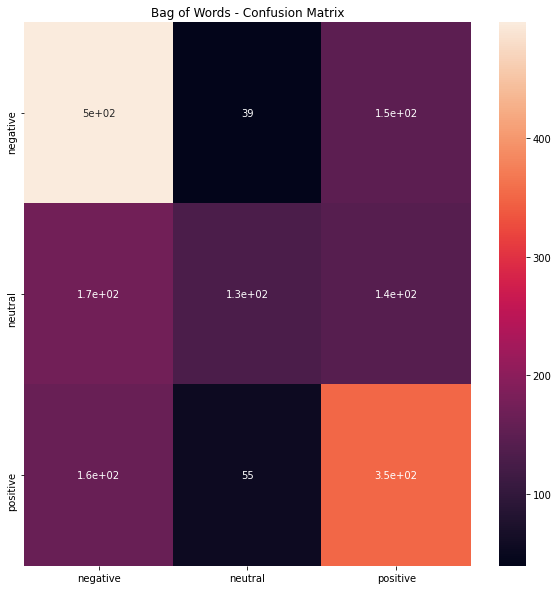

In [52]:
x_axis_labels = ['negative','neutral','positive']
y_axis_labels = ['negative','neutral','positive']

plt.figure(figsize=(10,10))
plt.title('Bag of Words - Confusion Matrix')
sns.heatmap(confusion_matrix(y_test_bow_cm,final_pred_bow),annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

### Insights Drawn

- from the confusion matrix for the test dataset with 1699 data points, we can see that:

    - 500: true negative

    - 350: true positive 

## 2/ Count Vectorizer Approach (using sklearn)

### Build the Vocab

In [ ]:
# create the transform
vectorizer_cv = CountVectorizer()

# tokenize and build vocab
vectorizer_cv.fit(tweet_text)

# review vocab 
print(len(vectorizer_cv.vocabulary_))

# encode all tweets 
vector_cv = vectorizer_cv.transform(tweet_text)

# summarize encoded vector
print(vector_cv.shape)
print(vector_cv.toarray().shape)
print(type(vector_cv.toarray()))

16415
(8493, 16415)
(8493, 16415)
<class 'numpy.ndarray'>


### Train-Test Split

In [ ]:
# split into train-test sets
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(vector_cv, tweet_sentiment_labels, test_size=0.20, random_state=0)

# check shape of count-vectorized training features
X_train_cv.shape

(6794, 16415)

In [ ]:
# check shape of count-vectorized test features
X_test_cv.shape

(1699, 16415)

In [ ]:
# check shape of count-vectorized training labels
y_train_cv.shape

(6794,)

In [ ]:
# check shape of count-vectorized test labels
y_test_cv.shape

(1699,)

In [ ]:
# check first 5 values of training labels 
y_train_cv.head()

1453    2
4601    1
3987    2
2252    0
3812    1
Name: sentiment_le, dtype: int64

In [ ]:
# check first 5 values of test labels 
y_test_cv.head()

4501    1
8414    0
683     2
5153    0
3646    1
Name: sentiment_le, dtype: int64

### Model Training - Logistic Regression (Count Vectorizer)

In [ ]:
# init blank logistic regression model for count vectorization
logistic_regression_count_vectorization = LogisticRegression(max_iter=500)

# fit the count vectorization logistic regression model with the training data
logistic_regression_count_vectorization.fit(X_train_cv,y_train_cv,)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Model Evaluation  (Count Vectorization)

In [ ]:
# count vectorization based predictions 
y_pred_cv = logistic_regression_count_vectorization.predict(X_test_cv)

# check the predictions 
y_pred_cv[:5]

array([0, 0, 2, 0, 2])

In [ ]:
y_pred_cv_series = pd.Series(y_pred_cv)
y_pred_cv_series.head()

0    0
1    0
2    2
3    0
4    2
dtype: int64

In [ ]:
y_pred_cv_series.value_counts()

0    684
2    619
1    396
dtype: int64

In [ ]:
# check the test data 
y_test_cv.head()

4501    1
8414    0
683     2
5153    0
3646    1
Name: sentiment_le, dtype: int64

In [ ]:
y_test_cv.value_counts()

#### Confusion Matrix

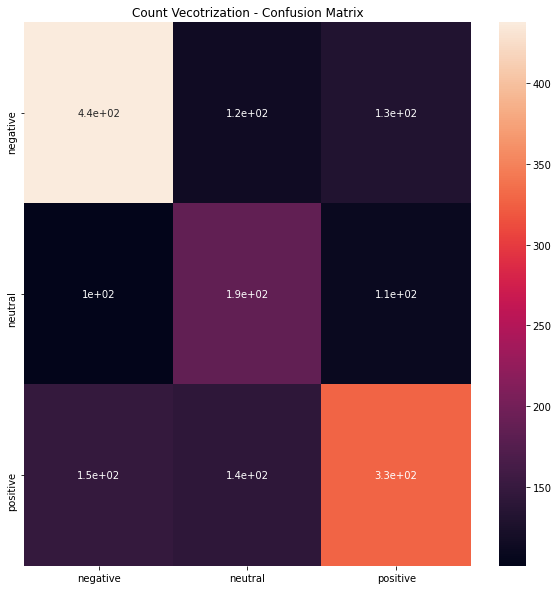

In [51]:
x_axis_labels = ['negative','neutral','positive']
y_axis_labels = ['negative','neutral','positive']

plt.figure(figsize=(10,10))
plt.title('Count Vecotrization - Confusion Matrix')
sns.heatmap(confusion_matrix(pd.Series(y_pred_cv), y_test_cv),annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

### Insights Drawn

- from the confusion matrix for the test dataset with 1699 data points, we can see that:

    - 440: true negative

    - 330: true positive 

## 3/ TF-IDF Approach (using sklearn)

### Build the Vocab

In [57]:
# create the transform
vectorizer_tfidf = TfidfVectorizer()

# tokenize and build vocab
vectorizer_tfidf.fit(tweet_text)

# review vocab 
# print(vectorizer_tfidf.vocabulary_)
print(len(vectorizer_tfidf.vocabulary_))

# review the idf 
print(vectorizer_tfidf.idf_)
print(len(vectorizer_tfidf.idf_))

# encode all tweets 
vector_tfidf = vectorizer_tfidf.transform(tweet_text)

# summarize encoded vector
print(vector_tfidf.shape)
print(vector_tfidf.toarray().shape)
print(type(vector_tfidf.toarray()))

16415
[8.10120516 8.10120516 9.35396813 ... 7.96767377 9.35396813 8.66082095]
16415
(8493, 16415)
(8493, 16415)
<class 'numpy.ndarray'>


### Train-Test Split

In [59]:
# split into train-test sets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(vector_tfidf, tweet_sentiment_labels, test_size=0.20, random_state=0)

# check shape of count-vectorized training features
X_train_tfidf.shape

(6794, 16415)

In [60]:
# check shape of count-vectorized test features
X_test_tfidf.shape

(1699, 16415)

In [61]:
# check shape of count-vectorized training labels
y_train_tfidf.shape

(6794,)

In [62]:
# check shape of count-vectorized test labels
y_test_tfidf.shape

(1699,)

In [63]:
# check first 5 values of training labels 
y_train_tfidf.head()

1453    2
4601    1
3987    2
2252    0
3812    1
Name: sentiment_le, dtype: int64

In [64]:
# check first 5 values of test labels 
y_test_tfidf.head()

4501    1
8414    0
683     2
5153    0
3646    1
Name: sentiment_le, dtype: int64

### Model Training - Logistic Regression (TF-IDF)

In [65]:
# init blank logistic regression model for tf-idf
logistic_regression_tf_idf = LogisticRegression(max_iter=500)

# fit the tf-idf logistic regression model with the training data
logistic_regression_tf_idf.fit(X_train_tfidf,y_train_tfidf,)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Model Evaluation (TF-IDF)

In [68]:
# tf-idf based predictions 
y_pred_tfidf = logistic_regression_tf_idf.predict(X_test_cv)

# check the predictions 
y_pred_tfidf[:5]

array([0, 0, 2, 0, 0])

In [69]:
y_pred_tfidf_series = pd.Series(y_pred_tfidf)
y_pred_tfidf_series.head()

0    0
1    0
2    2
3    0
4    0
dtype: int64

In [73]:
y_pred_tfidf_series.value_counts()

0    904
2    695
1    100
dtype: int64

In [72]:
# check the test data 
y_test_tfidf.head()

4501    1
8414    0
683     2
5153    0
3646    1
Name: sentiment_le, dtype: int64

In [74]:
y_test_tfidf.value_counts()

0    687
2    568
1    444
Name: sentiment_le, dtype: int64

#### Confusion Matrix

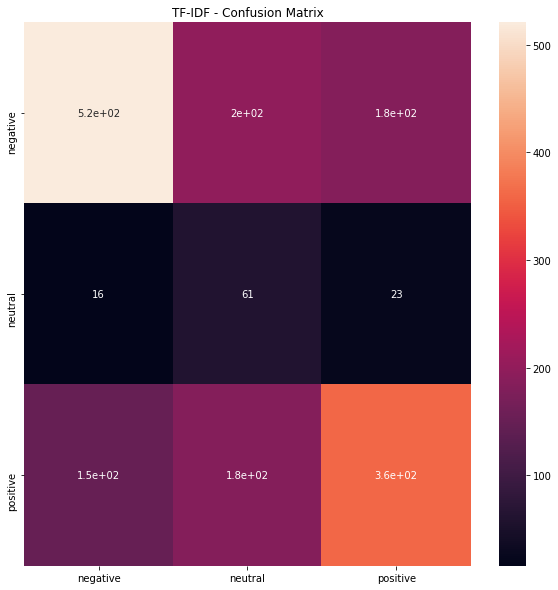

In [75]:
x_axis_labels = ['negative','neutral','positive']
y_axis_labels = ['negative','neutral','positive']

plt.figure(figsize=(10,10))
plt.title('TF-IDF - Confusion Matrix')
sns.heatmap(confusion_matrix(pd.Series(y_pred_tfidf), y_test_tfidf),annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

### Insights Drawn

- from the confusion matrix for the test dataset with 1699 data points, we can see that:

    - 520: true negative

    - 360: true positive 

## 4/ Hashed Vectorization Approach (using sklearn)

### Build the Vocab

In [94]:
# create the transform
vectorizer_hv = HashingVectorizer(n_features=200)

# encode document
vector_hv = vectorizer_hv.transform(tweet_text)

# summarize encoded vector
print(vector_hv.shape)
print(vector_hv.toarray())
print(vector_hv.toarray().shape)

(8493, 200)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ... -0.20851441  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.37796447]]
(8493, 200)


### Train-Test Split

In [95]:
# split into train test sets
X_train_hv, X_test_hv, y_train_hv, y_test_hv = train_test_split(vector_hv, tweet_sentiment_labels, test_size=0.20, random_state=0)

# check shape of count-vectorized training features
X_train_hv.shape

(6794, 200)

In [96]:
# check shape of count-vectorized test features
X_test_hv.shape

(1699, 200)

In [97]:
# check shape of count-vectorized training labels
y_train_hv.shape

(6794,)

In [98]:
# check shape of count-vectorized test labels
y_test_hv.shape

(1699,)

In [99]:
# check first 5 values of training labels 
y_train_hv.head()

1453    2
4601    1
3987    2
2252    0
3812    1
Name: sentiment_le, dtype: int64

In [100]:
# check first 5 values of test labels 
y_test_hv.head()

4501    1
8414    0
683     2
5153    0
3646    1
Name: sentiment_le, dtype: int64

### Model Training - Logistic Regression (Hash Vectorization)

In [101]:
# init blank logistic regression model for tf-idf
logistic_regression_hv = LogisticRegression(max_iter=500)

# fit the tf-idf logistic regression model with the training data
logistic_regression_hv.fit(X_train_hv,y_train_hv,)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Model Evaluation (Hash Vectorization)

In [102]:
# tf-idf based predictions 
y_pred_hv = logistic_regression_hv.predict(X_test_hv)

# check the predictions 
y_pred_hv[:5]

array([1, 0, 2, 0, 2])

In [103]:
y_pred_hv_series = pd.Series(y_pred_hv)
y_pred_hv_series.head()

0    1
1    0
2    2
3    0
4    2
dtype: int64

In [104]:
y_pred_hv_series.value_counts()

0    874
2    611
1    214
dtype: int64

In [105]:
# check the test data 
y_test_hv.head()

4501    1
8414    0
683     2
5153    0
3646    1
Name: sentiment_le, dtype: int64

In [106]:
y_test_hv.value_counts()

0    687
2    568
1    444
Name: sentiment_le, dtype: int64

#### Confusion Matrix

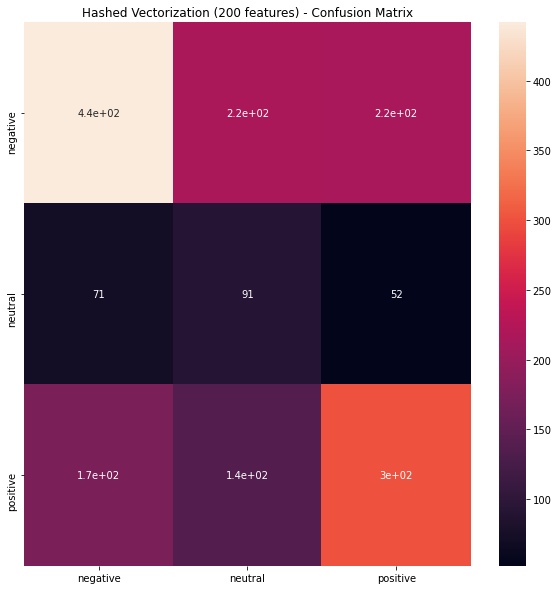

In [109]:
x_axis_labels = ['negative','neutral','positive']
y_axis_labels = ['negative','neutral','positive']

plt.figure(figsize=(10,10))
plt.title('Hashed Vectorization (200 features) - Confusion Matrix')
sns.heatmap(confusion_matrix(pd.Series(y_pred_hv), y_test_hv),annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

### Insights Drawn

- from the confusion matrix for the test dataset with 1699 data points, we can see that:

    - 440: true negative

    - 300: true positive 

## Comparison

Text(0.5, 1.0, 'Hashed Vectorization (200 Hash Values)')

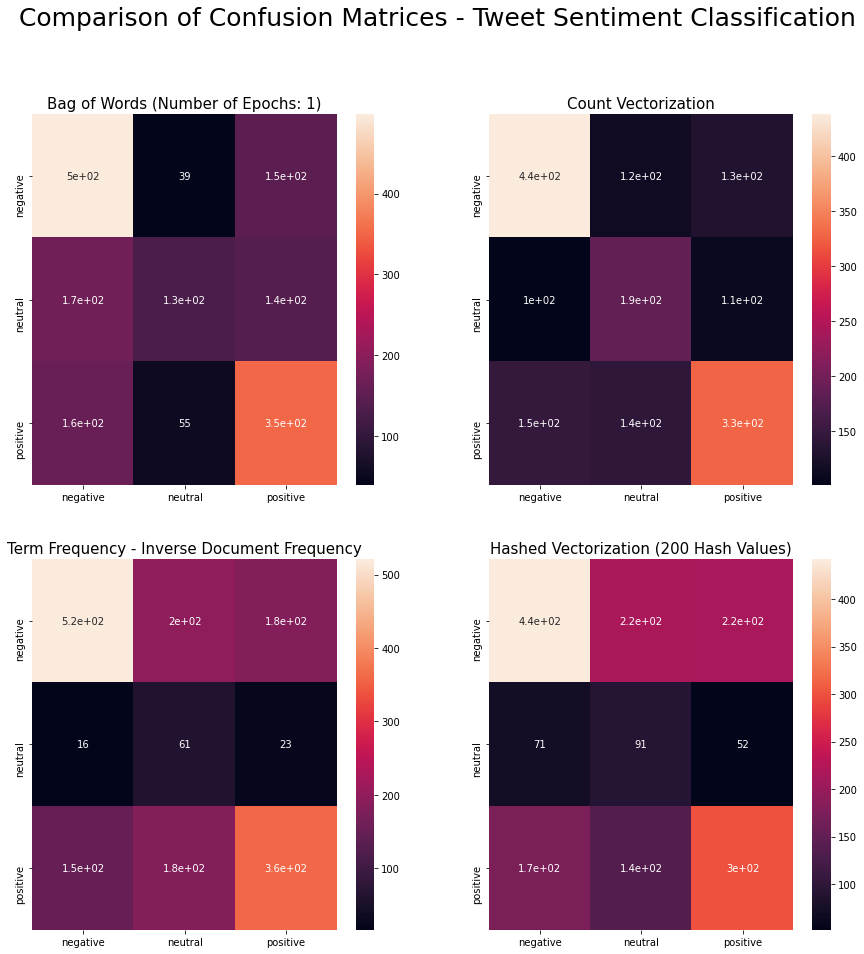

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Comparison of Confusion Matrices - Tweet Sentiment Classification', fontsize = 25)

sns.heatmap(ax=axes[0, 0], data=confusion_matrix(y_test_bow_cm,final_pred_bow),annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
axes[0,0].set_title('Bag of Words (Number of Epochs: ' + str(number_of_epochs) +')' , fontsize = 15) 

sns.heatmap(ax=axes[0, 1], data=confusion_matrix(pd.Series(y_pred_cv), y_test_cv),annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
axes[0,1].set_title('Count Vectorization', fontsize = 15) 

sns.heatmap(ax=axes[1, 0], data=confusion_matrix(pd.Series(y_pred_tfidf), y_test_tfidf),annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
axes[1,0].set_title('Term Frequency - Inverse Document Frequency', fontsize = 15) 

sns.heatmap(ax=axes[1, 1], data=confusion_matrix(pd.Series(y_pred_hv), y_test_hv),annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
axes[1,1].set_title('Hashed Vectorization (200 Hash Values)', fontsize = 15) 

# Resources

- [How to Encode Text Data for Machine Learning with scikit-learn](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

- [Sentiment Analysis of YouTube Comments](https://www.analyticssteps.com/blogs/sentiment-analysis-youtube-comments)